In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pymbar import MBAR, timeseries

import simtk.unit as simtk_unit
from simtk.openmm.app import (
    AmberPrmtopFile,
    AmberInpcrdFile,
    Simulation,
    HBonds,
    PME,
    DCDReporter,
    StateDataReporter,
    PDBFile,
)
from simtk.openmm import (
    XmlSerializer,
    LangevinIntegrator,
    MonteCarloBarostat,
    CustomNonbondedForce,
    CustomBondForce,
    NonbondedForce,
    Platform,
)

### Functions to add `lambda_sterics`

In [2]:
def add_LJ_scaling(
    system, molecule, solvent, lambda_value=1.0, force_group_1=6, force_group_2=5
):
    """
    * move the Intermolecular LJ to `CustomNonbonded`
    * add lambda scaling to intermolecular LJ
    * move the Intramolecular LJ to `CustomBondForce`

    Parameters
    ----------
    system: openmm.System
        The OpenMM system containing the nonbonded force.
    molecule: list
        A list of atom indices (starts from 0) for the molecule of interest.
    solvent: list
        A list of atom indicies (starts from 0) for the solvent molecules.
    lambda_value: float
        The starting lambda value for the Elec scaling.
    force_group_1: int
        Force group number for the intermolecular LJ
    force_group_2: int
        Force group number for the intramolecular LJ
    """
    nonbonded = [
        force for force in system.getForces() if isinstance(force, NonbondedForce)
    ][0]

    # Intermolecular LJ - softcore potential added
    intermol_LJ = CustomNonbondedForce(
        "(lambda_sterics^softcore_a)*4*epsilon*x*(x-1.0);"
        "x=(sigma/reff_sterics)^6;"
        "reff_sterics=sigma*((softcore_alpha*(1.0-lambda_sterics)^softcore_b+(r/sigma)^softcore_c))^(1/softcore_c);"
        "sigma=0.5*(sigma1+sigma2);"
        "epsilon=sqrt(epsilon1*epsilon2);"
    )
    intermol_LJ.addGlobalParameter("lambda_sterics", lambda_value)
    intermol_LJ.addGlobalParameter("softcore_a", 1)
    intermol_LJ.addGlobalParameter("softcore_b", 1)
    intermol_LJ.addGlobalParameter("softcore_c", 6)
    intermol_LJ.addGlobalParameter("softcore_alpha", 0.5)
    intermol_LJ.addPerParticleParameter("sigma")
    intermol_LJ.addPerParticleParameter("epsilon")
    intermol_LJ.setCutoffDistance(nonbonded.getCutoffDistance())
    intermol_LJ.setNonbondedMethod(CustomNonbondedForce.CutoffPeriodic)
    intermol_LJ.setUseLongRangeCorrection(nonbonded.getUseDispersionCorrection())
    intermol_LJ.addInteractionGroup(molecule, solvent)
    intermol_LJ.setForceGroup(force_group_1)

    # Add Particles to the `intermol_LJ`
    for atom_i in range(nonbonded.getNumParticles()):
        charge, sigma, epsilon = nonbonded.getParticleParameters(atom_i)
        intermol_LJ.addParticle([sigma, epsilon])

    # Copy Exceptions to `intermol_LJ`
    for exception_i in range(nonbonded.getNumExceptions()):
        atom_i, atom_j, chargeprod, sigma, epsilon = nonbonded.getExceptionParameters(
            exception_i
        )
        intermol_LJ.addExclusion(atom_i, atom_j)

    system.addForce(intermol_LJ)

    # Intramolecular LJ
    intramol_LJ = CustomBondForce("4*epsilon*((sigma/r)^12 - (sigma/r)^6);")
    intramol_LJ.addPerBondParameter("sigma")
    intramol_LJ.addPerBondParameter("epsilon")
    intramol_LJ.setForceGroup(force_group_2)

    for exception_i in range(nonbonded.getNumExceptions()):
        atom_i, atom_j, charge, sigma, epsilon = nonbonded.getExceptionParameters(
            exception_i
        )
        if atom_i in molecule and atom_j in molecule:
            intramol_LJ.addBond(atom_i, atom_j, [sigma, epsilon])

    system.addForce(intramol_LJ)

In [3]:
def turn_off_nonbonded(system, molecule):
    """
    * Turn off the LJ parameters in `NonbondedForce` for the molecule

    Parameters
    ----------
    system: openmm.System
        The OpenMM system containing the nonbonded force.
    molecule: list
        A list of atom indices (starts from 0) for the molecule of interest.
    """
    nonbonded = [
        force for force in system.getForces() if isinstance(force, NonbondedForce)
    ][0]

    # Turn off Elec and LJ parameters
    for atom_i in molecule:
        charge, sigma, epsilon = nonbonded.getParticleParameters(atom_i)
        nonbonded.setParticleParameters(atom_i, 0.0, sigma, 0.0)

    # Turn off Elec and LJ Exceptions
    for exception_i in range(nonbonded.getNumExceptions()):
        atom_i, atom_j, charge, sigma, epsilon = nonbonded.getExceptionParameters(
            exception_i
        )
        if atom_i in molecule and atom_j in molecule:
            nonbonded.setExceptionParameters(
                exception_i, atom_i, atom_j, 0.0, sigma, 0.0
            )

# Initial Setup

In [4]:
build_folder = "build_files"
work_folder = "vdw-bulk"
os.makedirs(work_folder, exist_ok=True)

In [5]:
platform = Platform.getPlatformByName("CUDA")
platform.setPropertyDefaultValue("DeviceIndex", "0")
platform.setPropertyDefaultValue("Precision", "mixed")

In [6]:
prmtop = AmberPrmtopFile(f"{build_folder}/ethanol_tip3p.prmtop")
inpcrd = AmberInpcrdFile(f"{build_folder}/ethanol_tip3p.rst7")

In [7]:
ethanol = [atom.index for atom in prmtop.topology.atoms() if atom.residue.name == "MOL"]
solvent = [atom.index for atom in prmtop.topology.atoms() if atom.residue.name == "HOH"]

In [8]:
system = prmtop.createSystem(
    nonbondedMethod=PME,
    nonbondedCutoff=9.0 * simtk_unit.angstrom,
    rigidWater=True,
    constraints=HBonds,
)

In [9]:
temperature = 298.15 * simtk_unit.kelvin
pressure = 1.01325 * simtk_unit.bar
friction = 1.0 / simtk_unit.picosecond
timestep = 2.0 * simtk_unit.femtosecond
kT = temperature * simtk_unit.BOLTZMANN_CONSTANT_kB * simtk_unit.AVOGADRO_CONSTANT_NA

In [10]:
barostat = MonteCarloBarostat(pressure, temperature, 100)
system.addForce(barostat)

5

In [11]:
add_LJ_scaling(system, ethanol, solvent, lambda_value=0.0)
turn_off_nonbonded(system, ethanol)

In [12]:
with open(f"{work_folder}/system.xml", "w") as f:
    f.write(XmlSerializer.serialize(system))

# MD Simulation

In [13]:
integrator = LangevinIntegrator(temperature, friction, timestep)

simulation = Simulation(
    prmtop.topology,
    system,
    integrator,
    platform,
)
simulation.context.setPositions(inpcrd.positions)

## 01. Minimization

In [14]:
simulation.minimizeEnergy(
    tolerance=1.0 * simtk_unit.kilojoules_per_mole, maxIterations=5000
)

## 02. Equilibration

In [15]:
output_freq = 5000
equil_steps = 100000

In [16]:
dcd_reporter = DCDReporter(f"{work_folder}/equilibration.dcd", output_freq)
state_reporter = StateDataReporter(
    f"{work_folder}/equilibration.log",
    output_freq,
    step=True,
    kineticEnergy=True,
    potentialEnergy=True,
    totalEnergy=True,
    temperature=True,
    volume=True,
    speed=True,
    separator=",",
)
simulation.reporters.append(dcd_reporter)
simulation.reporters.append(state_reporter)

In [17]:
simulation.step(equil_steps)

In [18]:
simulation.saveState(f"{work_folder}/equilibration.xml")
with open(f"{work_folder}/equilibration.pdb", "w") as f:
    PDBFile.writeModel(
        prmtop.topology,
        simulation.context.getState(getPositions=True).getPositions(),
        f,
    )

## 03. Alchemical Run

In [19]:
lambda_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
n_lambda = len(lambda_values)

output_freq = 500
equil_steps = 50000
prod_steps = 100000

total_iterations = int(prod_steps / output_freq)

u_kln = np.zeros((n_lambda, n_lambda, total_iterations))

In [20]:
integrator = LangevinIntegrator(temperature, friction, timestep)

simulation = Simulation(
    prmtop.topology,
    system,
    integrator,
    platform,
)
simulation.loadState(f"{work_folder}/equilibration.xml")

In [21]:
for k, lb1 in enumerate(lambda_values):
    print(f"Running simulation for lambda: {lb1} ...")

    simulation.context.setParameter("lambda_sterics", lb1)

    # Short equilibration
    simulation.step(equil_steps)

    # Add reporters
    dcd_reporter = DCDReporter(f"{work_folder}/production-{k}.dcd", output_freq)
    state_reporter = StateDataReporter(
        f"{work_folder}/production-{k}.log",
        output_freq,
        step=True,
        kineticEnergy=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True,
        volume=True,
        speed=True,
        separator=",",
    )
    simulation.reporters.append(dcd_reporter)
    simulation.reporters.append(state_reporter)

    # Run production
    for n in range(total_iterations):
        simulation.context.setParameter("lambda_sterics", lb1)
        simulation.step(output_freq)

        for l, lb2 in enumerate(lambda_values):
            simulation.context.setParameter("lambda_sterics", lb2)
            u_kln[k, l, n] = (
                simulation.context.getState(getEnergy=True).getPotentialEnergy() / kT
            )

    simulation.saveState(f"{work_folder}/production-{k}.xml")

    simulation.reporters.pop(-1)
    simulation.reporters.pop(-1)

Running simulation for lambda: 0.0 ...
Running simulation for lambda: 0.1 ...
Running simulation for lambda: 0.2 ...
Running simulation for lambda: 0.3 ...
Running simulation for lambda: 0.4 ...
Running simulation for lambda: 0.5 ...
Running simulation for lambda: 0.6 ...
Running simulation for lambda: 0.7 ...
Running simulation for lambda: 0.8 ...
Running simulation for lambda: 0.9 ...
Running simulation for lambda: 1.0 ...


In [22]:
np.save(f"{work_folder}/reduced_elec_bulk_potential.npy", u_kln)

# Analysis

In [23]:
# Subsample data to extract uncorrelated equilibrium timeseries
N_k = np.zeros([n_lambda], np.int32)

for k in range(n_lambda):
    [nequil, g, Neff_max] = timeseries.detectEquilibration(u_kln[k, k, :])
    indices = timeseries.subsampleCorrelatedData(u_kln[k, k, :], g=g)
    N_k[k] = len(indices)
    u_kln[k, :, 0 : N_k[k]] = u_kln[k, :, indices].T

In [24]:
mbar = MBAR(u_kln, N_k)
[DeltaF_ij, dDeltaF_ij, Theta_ij] = mbar.getFreeEnergyDifferences(return_theta=True)
ODeltaF_ij = mbar.computeOverlap()["matrix"]

In [25]:
convert_kcalmol = kT.value_in_unit(simtk_unit.kilocalorie_per_mole)
for k, lb in enumerate(lambda_values):
    print(
        f"{lb} = {DeltaF_ij[0,k]*convert_kcalmol:.2f} +- {dDeltaF_ij[0,k]*convert_kcalmol:.2f} kcal/mol"
    )

0.0 = 0.00 +- 0.00 kcal/mol
0.1 = 0.24 +- 0.02 kcal/mol
0.2 = 1.00 +- 0.05 kcal/mol
0.3 = 1.92 +- 0.10 kcal/mol
0.4 = 2.51 +- 0.14 kcal/mol
0.5 = 2.76 +- 0.16 kcal/mol
0.6 = 2.79 +- 0.18 kcal/mol
0.7 = 2.65 +- 0.18 kcal/mol
0.8 = 2.41 +- 0.19 kcal/mol
0.9 = 2.11 +- 0.20 kcal/mol
1.0 = 1.78 +- 0.20 kcal/mol


Text(0, 0.5, 'overlap fraction')

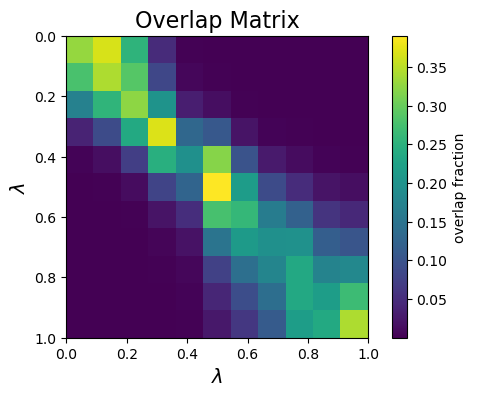

In [29]:
plt.figure(dpi=100)
plt.imshow(ODeltaF_ij, extent=[0, 1, 1, 0])
plt.xlabel(r"$\lambda$", fontsize=14)
plt.ylabel(r"$\lambda$", fontsize=14)
plt.title("Overlap Matrix", fontsize=16)
# plt.clim(0,1)
cbar = plt.colorbar()
cbar.ax.set_ylabel("overlap fraction")